<a href="https://colab.research.google.com/github/DanHyu0205/flask-study-planner/blob/main/CW_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **CW Attack 공격 실습**

* 본 실습에서는 Inception v3 모델을 공격 대상으로 설정하여 공격합니다.
  * **Targeted attack**: 하나의 **얼룩 고양이(tabby cat)** 이미지를 **까치(magpie)로 인식하도록** 만들어 봅시다.
  * **White-box attack**: 공격자가 공격 대상 모델의 **파라미터를 모두 알고 있다고** 가정합니다.
  * **Unrestricted attack**: 이미지 변경이 눈에 띄지 않아야 하므로 L2 거리상으로 최대한 적게 변경되도록 합니다.
    * **Restricted attack**으로 사용하는 경우에는 이분 탐색을 통해 크기 제약을 벗어나지 않는 노이즈를 찾을 수 있습니다.
* 코드 실행 전에 **\[런타임\]** → **\[런타임 유형 변경\]** → 유형을 **GPU**로 설정합니다.

In [43]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [44]:
# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### **이미지넷(ImageNet)에 정의된 클래스 정보 가져오기**

In [45]:
from urllib.request import urlretrieve
import json

# 이미지넷(ImageNet)에 정의된 1,000개의 레이블(클래스) 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [46]:
# 인덱스(index) 18에 해당하는 클래스는 까치(magpie)입니다.
print(imagenet_labels[18])

magpie


#### **이미지 처리 함수 정의 및 이미지 가져와 출력해보기**

* 공격 대상으로 설정한 Inception v3은 이미지에 대하여 **Resize**, **CenterCrop**, **ToTensor()**와 **입력 데이터 정규화**를 사용하는 모델입니다.
* 공격자는 이러한 사실을 이미 알고 있다고 가정(white-box)하며 공격용 이미지를 먼저 torch.Tensor 형태로 만듭니다.

In [47]:
imsize = 299

preprocess = transforms.Compose([
    transforms.Resize(imsize), # 이미지의 크기를 변경
    transforms.CenterCrop(imsize), # 이미지의 중앙 부분을 잘라서 크기 조절
    transforms.ToTensor(), # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
])

In [48]:
# 이미지(그림) 출력 관련 라이브러리
import matplotlib.pyplot as plt
import PIL

In [49]:
# 특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기

In [50]:
# 실제로 특정 URL에서 이미지를 불러오기 (얼룩 고양이)
url = "https://images.unsplash.com/photo-1604444506921-bdd3442e66c2?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [51]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)

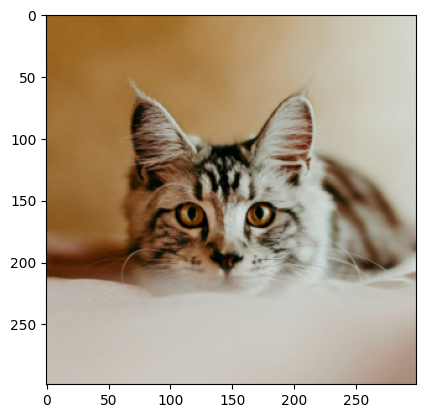

In [52]:
plt.figure()
imshow(image)

#### **사전 학습된(pretrained) 모델을 불러와 사용해보기**

In [53]:
# 입력 데이터 정규화를 위한 클래스 정의
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))

    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [54]:
# 공격자가 가지고 있는 torch.Tensor 형식의 이미지 데이터는 입력 정규화를 거치기 전이므로, 정규화 이후에 모델에 넣도록 설정
model = nn.Sequential(
    # 기본적인 Inception v3와 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
).to(device).eval() # 모델을 GPU로 옮기기 및 평가(테스트) 모드로 변경

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [55]:
# 기본적인 이미지를 실제 모델에 넣어 결과 확인
outputs = model(image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 285 / 클래스명: Egyptian cat / 확률: 37.9195%
인덱스: 282 / 클래스명: tiger cat / 확률: 33.9127%
인덱스: 281 / 클래스명: tabby, tabby cat / 확률: 24.1969%
인덱스: 287 / 클래스명: lynx, catamount / 확률: 0.3157%
인덱스: 728 / 클래스명: plastic bag / 확률: 0.1365%


#### **CW 공격 함수 정의**

In [58]:
import torch.optim as optim

# CW 공격 함수
def cw_attack(model, images, labels, targeted, c, k, iters, lr):
    # 이미지와 레이블 데이터를 GPU로 옮기기
    images = images.to(device)
    labels = labels.to(device)

    # 논문의 f(x) 함수 정의하기(실제로 클래스의 결과를 바꾸는 부분)
    def f(x):
        outputs = model(x)
        # 설정한 레이블의 인덱스만 1의 값을 가지는 one-hot 벡터 생성
        one_hot_labels = torch.eye(len(outputs[0]), device="cuda")[labels].to(device)

        # 설정한 레이블을 제외한 클래스 중에서 가장 큰 값 추출
        i, _ = torch.max((1 - one_hot_labels) * outputs, dim=1)
        # 설정한 레이블의 값 추출
        j = torch.masked_select(outputs, one_hot_labels.bool())

        # (설정한 레이블이 아닌 가장 큰 클래스 값 - 설정한 클래스 값) 계산
        if targeted:
            # 선택한 레이블의 값이 더 커지는 방향으로 처리하되, 충분히 공격에 성공했다면(k로 조절) 멈추기
            return torch.clamp(i - j, min=-k) # 값이 k 이하인 경우 0으로 처리
        else:
            # 다른 클래스의 값이 더 커지는 방향으로 갱신하되, 충분히 공격에 성공했다면(k로 조절) 멈추기
            return torch.clamp(j - i, min=-k) # 값이 k 이하인 경우 0으로 처리

    # 입력 이미지와 동일한 크기를 갖는 빈 이미지를 생성(adversarial example 자체를 생성)
    adv_image = torch.zeros_like(images).to(device)
    adv_image.requires_grad = True

    # 노이즈(perturbation)에 대하여 최적화를 진행
    optimizer = optim.Adam([adv_image], lr=lr)

    for i in range(iters):
        # Adversarial example의 크기를 [0, 1] 사이의 값으로 조절
        box_constrained_adv_image = 1 / 2 * (nn.Tanh()(adv_image) + 1)

        # 원본 이미지와의 L2 거리를 계산
        loss1 = nn.MSELoss(reduction='sum')(box_constrained_adv_image, images)

        # 원하는 분류(Classification) 결과가 나오도록 만들기
        loss2 = torch.sum(c * f(box_constrained_adv_image))

        cost = loss1 + loss2

        # 손실 함수에 대하여 미분하여 기울기(gradient) 계산하여 업데이트
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # 공격 시간이 길기 때문에 경과 내용 출력
        if i % 100 == 0:
            print("Step:", i, "/ Cost:", cost.item())

    # 최종적으로 만들어진 적대적 예제(adversarial example) 반환
    box_constrained_adv_image = 1 / 2 * (nn.Tanh()(adv_image) + 1).detach_()

    return box_constrained_adv_image

#### **Target Attack 예시**

In [59]:
# 공격용 파라미터 설정
targeted = True
c = 100 # 클래스 결과 바꾸기에 투자할 비율
k = 0 # 공격에 성공하면 분류 결과 바꾸기에 더 투자하기 않도록 하기
iters = 1000 # 최적화 진행 스텝 수
lr = 0.01

# 까치(magpie)로 분류되도록 공격 수행
label = [18]
label = torch.Tensor(label)
label = label.type(torch.long)

adv_image = cw_attack(model, image, label, targeted, c, k, iters, lr)

Step: 0 / Cost: 14792.7939453125
Step: 100 / Cost: 8070.44091796875
Step: 200 / Cost: 3992.129638671875
Step: 300 / Cost: 2100.510986328125
Step: 400 / Cost: 1185.977294921875
Step: 500 / Cost: 723.636474609375
Step: 600 / Cost: 511.199951171875
Step: 700 / Cost: 346.56927490234375
Step: 800 / Cost: 281.31182861328125
Step: 900 / Cost: 199.9774932861328


In [60]:
# 완성된 공격 이미지를 실제 모델에 넣어 결과 확인
outputs = model(adv_image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 18 / 클래스명: magpie / 확률: 14.7116%
인덱스: 91 / 클래스명: coucal / 확률: 2.5053%
인덱스: 81 / 클래스명: ptarmigan / 확률: 2.1263%
인덱스: 17 / 클래스명: jay / 확률: 1.9393%
인덱스: 748 / 클래스명: purse / 확률: 1.3917%


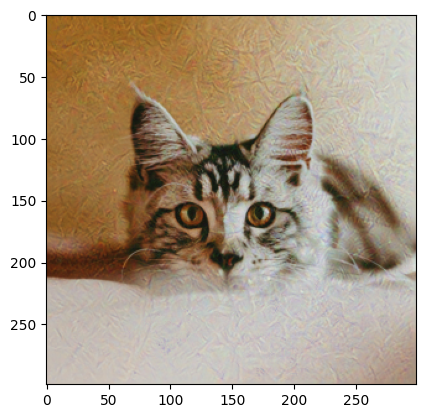

In [61]:
# 최종적으로 만들어진 공격 이미지 출력
plt.figure()
imshow(adv_image)